In [32]:
import numpy as np
#from jax import grad, jit, vmap
from scipy.integrate import dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Laplace equation with Dirichlet boundary conditions in 2D on a square domain using the finite element method. 

The Laplace equation is given by: 

$\nabla^2 u = 0$ on $\Omega$

where $\Omega$ is the domain of interest.

and the Dirichlet boundary conditions are given by:

$u = g(x,y)$ on $\partial \Omega$

where $\partial \Omega$ is the boundary of the domain.

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Laplace equation is given by:

$\int_{\Omega} \nabla^2 u v d\Omega = 0$

where $v$ is a test function.

After applying Green's first identity, we get:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot n v d\partial \Omega = 0$

where $n$ is the outward normal vector to the boundary.

In this case, we assume that our test function vanishes on the boundary, i.e. $v = 0$ on $\partial \Omega$. This simplifies the equation to:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega = 0$

And the boundary conditions is enforced by setting $u = g(x,y)$ on $\partial \Omega$.

To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v) = u$

$\phi_2(u,v) = v$

$\phi_3(u,v) = 1-u-v$

Where $u$, $v$, and $w=1-u-v$ are the barycentric coordinates of a point in the element.

In [33]:
def basis_fn_1(u, v): return u
def basis_fn_2(u, v): return v
def basis_fn_3(u, v): return 1 - u - v

grad_basis_fn_1 = np.array([1, 0])
grad_basis_fn_2 = np.array([0, 1])
grad_basis_fn_3 = np.array([-1, -1])

basis_fn_lst = [basis_fn_1, basis_fn_2, basis_fn_3]
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3]
n_local_basis_fn = len(basis_fn_lst)

In [34]:
#Load the square triangulated mesh
mesh = tm.load_mesh('unstructured_square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

#Remove the z component of the mesh
mesh.vertices = mesh.vertices[:, :2]

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)

n_vertices = len(mesh.vertices)
n_faces = len(mesh.faces)
n_boundary_vertices = len(mesh.boundary_vertices_idx)

#Store the value of the field at the boundary points
mesh.boundary_values = np.zeros(n_boundary_vertices)

boundary_vertex_pos = mesh.vertices[mesh.boundary_vertices_idx]
mesh.boundary_values = np.where(np.abs(boundary_vertex_pos[:, 0] - 1) <= 0.1, np.sin(boundary_vertex_pos[:, 1]* np.pi), 0.0)
mesh.boundary_values = mesh.boundary_values[:, np.newaxis]

#np.sin(mesh.vertices[mesh.boundary_vertices_idx][:, 1] * np.pi)[:, np.newaxis] 


In [40]:
# For each triangle in the mesh we need to compute the Jacobian of the transformation from global to local coordinates
p1_ar = mesh.vertices[mesh.faces[:, 0]]
p2_ar = mesh.vertices[mesh.faces[:, 1]]
p3_ar = mesh.vertices[mesh.faces[:, 2]] 

p3_to_p1_ar = p1_ar - p3_ar
p3_to_p2_ar = p2_ar - p3_ar

jacobian_ar = np.zeros((n_faces, 2, 2))
jacobian_ar[:, 0, 0] = p3_to_p1_ar[:, 0]
jacobian_ar[:, 0, 1] = p3_to_p1_ar[:, 1]
jacobian_ar[:, 1, 0] = p3_to_p2_ar[:, 0]
jacobian_ar[:, 1, 1] = p3_to_p2_ar[:, 1] 

#Compute the determinant of the Jacobian
det_jacobian_ar = jacobian_ar[:, 0, 0] * jacobian_ar[:, 1, 1] - jacobian_ar[:, 0, 1] * jacobian_ar[:, 1, 0]

#Compute the inverse of the Jacobian
inv_jacobian_ar = np.zeros((n_faces, 2, 2))
inv_jacobian_ar[:, 0, 0] =  jacobian_ar[:, 1, 1]
inv_jacobian_ar[:, 0, 1] = -jacobian_ar[:, 0, 1]
inv_jacobian_ar[:, 1, 0] = -jacobian_ar[:, 1, 0]
inv_jacobian_ar[:, 1, 1] =  jacobian_ar[:, 0, 0]
inv_jacobian_ar /= det_jacobian_ar[:, np.newaxis, np.newaxis]

#This list stores the product of the gradient of the basis functions with the inverse of the Jacobian
grad_basis_fn_inv_jacobian_lst = [np.dot(inv_jacobian_ar, grad_basis_fn_lst[i]) for i in range(n_local_basis_fn)]

#Now we compute the local stiffness matrix for each triangle
local_stiffness_matrix_ar = np.zeros((n_faces, n_local_basis_fn, n_local_basis_fn))

for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
        local_stiffness_matrix_ar[:, i, j] =  0.5 * det_jacobian_ar * np.sum(grad_basis_fn_inv_jacobian_lst[i] * grad_basis_fn_inv_jacobian_lst[j], axis = 1)
        local_stiffness_matrix_ar[:, j, i] = local_stiffness_matrix_ar[:, i, j]


#Now we need to assemble the global stiffness matrix
row_id = np.repeat(mesh.faces, n_local_basis_fn).flatten()
col_id = np.tile(mesh.faces, n_local_basis_fn).flatten()
data   = local_stiffness_matrix_ar.flatten()

# Create the sparse global stiffness matrix
global_stiffness_matrix = csc_matrix((data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))
global_stiffness_matrix.sum_duplicates()

In [41]:
# Now we need to enforce the Dirichlet boundary conditions

# To do so, we delete all the columns that correspond to the boundary vertices
interior_mask = np.ones(n_vertices, dtype=bool)
interior_mask[mesh.boundary_vertices_idx] = False

# Select the columns that correspond to the interior vertices
global_stiffness_matrix_with_BC = global_stiffness_matrix[:, interior_mask]

# Select the columns that correspond to the boundary vertices
boundary_point_columns = -global_stiffness_matrix[:, ~interior_mask]

# Compute the right-hand side of the linear system
rhs = boundary_point_columns @ mesh.boundary_values

#Now delete the rows corresponding to the boundary vertices from the stiffness matrix and the right-hand side
global_stiffness_matrix_with_BC = global_stiffness_matrix_with_BC[interior_mask, :]
rhs = rhs[interior_mask]



print(global_stiffness_matrix_with_BC.shape)
print(rhs.shape)

(122, 122)
(122, 1)


[]

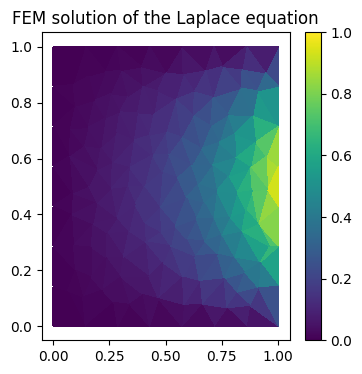

In [42]:
# Now we just have to solve the system of equations, to get the coefficients of the basis functions at the interior points
sol_interior = spsolve(global_stiffness_matrix_with_BC, rhs)

# We regroup the solution of the interior points with the boundary points
sol = np.zeros(n_vertices)

sol[interior_mask] = sol_interior
sol[~interior_mask] = mesh.boundary_values.flatten()

#Set the plot size 
plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()



[]

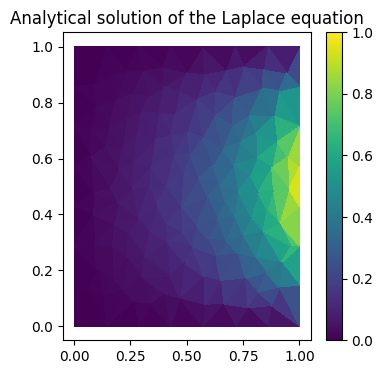

In [43]:
analytical_solution = np.sinh(mesh.vertices[:, 0] * np.pi)[:, np.newaxis] * np.sin(mesh.vertices[:, 1] * np.pi)[:, np.newaxis] / np.sinh(np.pi)

plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

[]

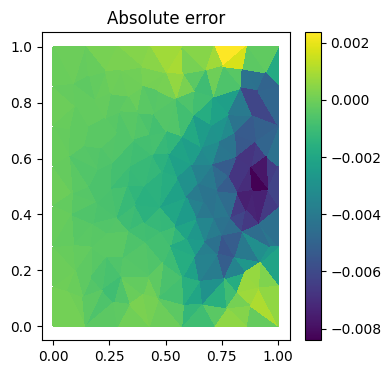

In [44]:
#Compute the relative error
absolute_error = (sol - analytical_solution.flatten()) 


plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, absolute_error, shading='flat')
plt.colorbar()
plt.title('Absolute error')
plt.plot()